In [54]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from IPython.display import display
import seaborn as sns

# Read raw population data

In [2]:
def prepare_total_pop():
    total_pop = pd.read_csv("../data/raw/WPP2019_TotalPopulationBySex.csv", sep=",", na_values='')
    total_pop = total_pop[total_pop["Time"] < 2020]
    total_pop.drop(columns=["LocID", "VarID", "Variant", "MidPeriod"], inplace=True)

    total_pop.columns = ["Country", "Year", "PopMale", "PopFemale", "PopTotal"]
    total_pop.set_index(["Country", "Year"], inplace=True)

    total_pop[["PopMale", "PopFemale", "PopTotal"]] = (total_pop[["PopMale", "PopFemale", "PopTotal"]].fillna(0) * 1000).astype("int64")
    return total_pop

def prepare_age_pop():
    age_pop = pd.read_csv("../data/raw/WPP2019_PopulationByAgeSex_Medium.csv", sep=",", na_values='')
    age_pop = age_pop[age_pop["Time"] < 2020]
    age_pop.drop(columns=["LocID", "VarID", "Variant", "MidPeriod", "AgeGrpStart", "AgeGrpSpan"], inplace=True)

    age_pop.columns = ["Country", "Year", "AgeGrp", "PopMale", "PopFemale", "PopTotal"]
    age_pop.set_index(["Country", "Year"], inplace=True)

    age_pop[["PopMale", "PopFemale", "PopTotal"]] = (age_pop[["PopMale", "PopFemale", "PopTotal"]].fillna(0) * 1000).astype("int64")
    return age_pop

In [3]:
pop_total = prepare_total_pop()
pop_per_age = prepare_age_pop()

In [4]:
pop_total.head(2)

PopMale  PopFemale  PopTotal
Country     Year                              
Afghanistan 1950  4099242    3652874   7752116
            1951  4134755    3705395   7840151

In [5]:
pop_per_age.head(2)

AgeGrp  PopMale  PopFemale  PopTotal
Country     Year                                     
Afghanistan 1950    0-4   630044     661578   1291622
            1950    5-9   516206     487335   1003541

# Rearrange Population data

## Aggregate the age groups in three larger groups, from 0-19, 20-59, and 60+ years

In [6]:
pop_per_age_young = pop_per_age.query('AgeGrp in ["0-4", "5-9", "10-14", "15-19"]').sum(level=['Country', 'Year'])
pop_per_age_young.rename(columns={"PopMale": "PopMale_0-19", "PopFemale": "PopFemale_0-19", "PopTotal" : "PopTotal_0-19"}, inplace=True)
pop_per_age_mid = pop_per_age.query('AgeGrp in ["20-24", "25-29", "30-34", "35-39", "40-44", "45-49","50-54", "55-59"]').sum(level=['Country', 'Year'])
pop_per_age_mid.rename(columns={"PopMale": "PopMale_20-59", "PopFemale": "PopFemale_20-59", "PopTotal" : "PopTotal_20-59"}, inplace=True)
pop_per_age_old = pop_per_age.query('AgeGrp in ["60-64", "65-69", "70-74", "75-79", "80-84", "85-89", "90-94", "95-99", "100+"]').sum(level=['Country', 'Year'])
pop_per_age_old.rename(columns={"PopMale": "PopMale_60+", "PopFemale": "PopFemale_60+", "PopTotal" : "PopTotal_60+"}, inplace=True)

## Merge age groups with total population

In [7]:
pop_with_groups = pop_per_age_young.merge(pop_per_age_mid, left_index=True, right_index=True)
pop_with_groups = pop_with_groups.merge(pop_per_age_old, left_index=True, right_index=True)
pop_total_with_groups = pop_total.merge(pop_with_groups, left_index=True, right_index=True)

# Load indicators dataset

In [8]:
indicators = pd.read_csv("../data/raw/WPP2019_Period_Indicators_Medium.csv", sep=",", na_values='')
indicators[["Births", "Deaths", "DeathsMale", "DeathsFemale", "NetMigrations"]] = (indicators[["Births", "Deaths", "DeathsMale", "DeathsFemale", "NetMigrations"]].fillna(0) * 1000 / 5).astype("int64")
indicators_pop = indicators.merge(pop_total_with_groups, left_on=['MidPeriod','Location'], right_on=['Year', 'Country'])
indicators_pop["RelMigrations"] = indicators_pop["NetMigrations"] / indicators_pop["PopTotal"]
indicators_pop.drop(columns=['VarID', 'Variant'], inplace=True)
indicators_pop.rename(columns={"Location" : "Country"}, inplace=True)

## Scale population columns by total population

In [9]:
scale_cols = ["Births", "Deaths", "DeathsMale", "DeathsFemale", "PopMale", "PopFemale", "PopMale_0-19", "PopFemale_0-19",
              "PopTotal_0-19", "PopMale_20-59", "PopFemale_20-59", "PopTotal_20-59", "PopMale_60+", "PopFemale_60+", "PopTotal_60+"]
indicators_pop[scale_cols] = indicators_pop[scale_cols].div(indicators_pop["PopTotal"], axis=0)

# Read fragile states data

In [10]:
years = list(range(2006,2020))

dfs = []
for year in years:
    df = pd.read_excel("../data/raw/fragile_states_index/fragile_states_index_" + str(year) + ".xlsx")
    df = df.assign(Year=[str(s).split('-')[0] for s in df['Year']])
    df = df.assign(Rank=[str(s)[:-2] for s in df['Rank']])
    dfs.append(df)

fragile_states = pd.concat(dfs, ignore_index=True, sort=False)

fragile_states.columns = ['country', 'year', 'ranking', 'total', 'security_apparatus',
       'factionalized_elites', 'group_grievance', 'economy',
       'economic_inequality', 'human_flight_and_brain_drain',
       'state_legitimacy', 'public_services', 'human_rights',
       'demographic_pressures', 'refugees_and_idps',
       'external_intervention', 'change_from_previous_year']
fragile_states["country"] = fragile_states["country"].str.strip()
fragile_states["year"] = fragile_states["year"].astype("int64")

## Merge it with `indicators_pop`

In [11]:
full_set = indicators_pop.merge(fragile_states, left_on=['Country','MidPeriod'], right_on=['country','year'])

## Concat not merged countries manually

In [12]:
missing_countries = list(set(fragile_states["country"]).difference(set(full_set["country"])))
missing_countries.remove("Eswatini")
missing_countries.remove("Czechia")
missing_countries.sort()
corresponding_countries = ["Bolivia (Plurinational State of)", "Cabo Verde", "Democratic Republic of the Congo", "Congo", "Côte d'Ivoire", "Czechia", "Guinea-Bissau", "Iran (Islamic Republic of)", "Israel", "Kyrgyzstan", "Lao People's Democratic Republic", "North Macedonia", "Republic of Moldova", "Dem. People's Republic of Korea", "Russian Federation", "Slovakia", "Republic of Korea", "Eswatini", "Syrian Arab Republic", "United Republic of Tanzania", "United States of America", "Venezuela (Bolivarian Republic of)", "Viet Nam"]
replacements = list(zip(missing_countries, corresponding_countries))
replacements

[('Bolivia', 'Bolivia (Plurinational State of)'),
 ('Cape Verde', 'Cabo Verde'),
 ('Congo Democratic Republic', 'Democratic Republic of the Congo'),
 ('Congo Republic', 'Congo'),
 ("Cote d'Ivoire", "Côte d'Ivoire"),
 ('Czech Republic', 'Czechia'),
 ('Guinea Bissau', 'Guinea-Bissau'),
 ('Iran', 'Iran (Islamic Republic of)'),
 ('Israel and West Bank', 'Israel'),
 ('Kyrgyz Republic', 'Kyrgyzstan'),
 ('Laos', "Lao People's Democratic Republic"),
 ('Macedonia', 'North Macedonia'),
 ('Moldova', 'Republic of Moldova'),
 ('North Korea', "Dem. People's Republic of Korea"),
 ('Russia', 'Russian Federation'),
 ('Slovak Republic', 'Slovakia'),
 ('South Korea', 'Republic of Korea'),
 ('Swaziland', 'Eswatini'),
 ('Syria', 'Syrian Arab Republic'),
 ('Tanzania', 'United Republic of Tanzania'),
 ('United States', 'United States of America'),
 ('Venezuela', 'Venezuela (Bolivarian Republic of)'),
 ('Vietnam', 'Viet Nam')]

In [13]:
for old, new in replacements:
    fragile_states["country"] = fragile_states["country"].str.replace(pat=old, repl=new)
fragile_states["country"].unique()

array(['Sudan', 'Democratic Republic of the Congo', "Côte d'Ivoire",
       'Iraq', 'Zimbabwe', 'Chad', 'Somalia', 'Haiti', 'Pakistan',
       'Afghanistan', 'Guinea', 'Liberia', 'Central African Republic',
       "Dem. People's Republic of Korea", 'Burundi', 'Sierra Leone',
       'Yemen', 'Myanmar', 'Bangladesh', 'Nepal', 'Uganda', 'Nigeria',
       'Uzbekistan', 'Rwanda', 'Sri Lanka', 'Ethiopia', 'Colombia',
       'Kyrgyzstan', 'Malawi', 'Burkina Faso', 'Egypt', 'Indonesia',
       'Kenya', 'Syrian Arab Republic', 'Bosnia and Herzegovina',
       'Cameroon', 'Angola', 'Togo', 'Bhutan',
       "Lao People's Democratic Republic", 'Mauritania', 'Tajikistan',
       'Russian Federation', 'Niger', 'Turkmenistan', 'Guinea-Bissau',
       'Cambodia', 'Dominican Republic', 'Papua New Guinea', 'Belarus',
       'Guatemala', 'Equatorial Guinea', 'Iran (Islamic Republic of)',
       'Eritrea', 'Serbia', 'Bolivia (Plurinational State of)', 'China',
       'Republic of Moldova', 'Nicaragua', 'G

## Merge again

In [14]:
full_set = indicators_pop.merge(fragile_states, left_on=['Country','MidPeriod'], right_on=['country','year'])

In [15]:
list(set(fragile_states["country"]).difference(set(full_set["country"])))

[]

## Drop unused/duplicated columns

In [18]:
indicators_pop.drop(columns=["LocID"], inplace=True)
full_set.drop(columns=["LocID"], inplace=True)

## Calculate the index change from the previous 5 year

In [19]:
query_result = full_set.query("Time == '2005-2010'")
full_set.loc[query_result.index, "change_from_previous_year"] = pd.Series(0, index=query_result.index)
previous = query_result
for years in ["2010-2015", "2015-2020"]:
    query_result = full_set.query("Time == '" + years + "'")
    full_set.loc[query_result.index, "change_from_previous_year"] = \
        (query_result.set_index("Country")["total"] - previous.set_index("Country")["total"]).round(1).fillna(0).to_numpy()
    previous = full_set.loc[query_result.index, :]

# Save all dataframes

In [20]:
pop_total.to_csv("../data/clean/population_total.csv")
pop_per_age.to_csv("../data/clean/population_per_age.csv")
indicators_pop.to_csv(index=False, path_or_buf="../data/clean/population_indicators.csv")
fragile_states.to_csv("../data/clean/fragile_states_index.csv")
full_set.to_csv(index=False, path_or_buf="../data/clean/full_set.csv")

# Check Missing Data

In [23]:
full_set.isnull().any()

Country                         False
Time                            False
MidPeriod                       False
TFR                             False
NRR                             False
CBR                             False
Births                          False
LEx                             False
LExMale                         False
LExFemale                       False
IMR                             False
Q5                              False
CDR                             False
Deaths                          False
DeathsMale                      False
DeathsFemale                    False
CNMR                            False
NetMigrations                   False
GrowthRate                      False
NatIncr                         False
SRB                             False
MAC                             False
PopMale                         False
PopFemale                       False
PopTotal                        False
PopMale_0-19                    False
PopFemale_0-

# Boxplots and Histograms
## Drop useless columns

In [25]:
drop_cols = ["Country", "Time", "MidPeriod", "country", "year", "ranking"]
small_set = full_set.drop(columns=drop_cols)

## Plot those with more than 3 outliers

In [28]:
plot_cols = [column for column in small_set.columns if len([y for stat in boxplot_stats(small_set[column]) for y in stat['fliers']]) > 3]
plot_cols

['LEx',
 'LExMale',
 'IMR',
 'Q5',
 'CDR',
 'Deaths',
 'DeathsMale',
 'DeathsFemale',
 'CNMR',
 'NetMigrations',
 'GrowthRate',
 'SRB',
 'PopMale',
 'PopFemale',
 'PopTotal',
 'PopMale_20-59',
 'PopTotal_20-59',
 'RelMigrations',
 'change_from_previous_year']

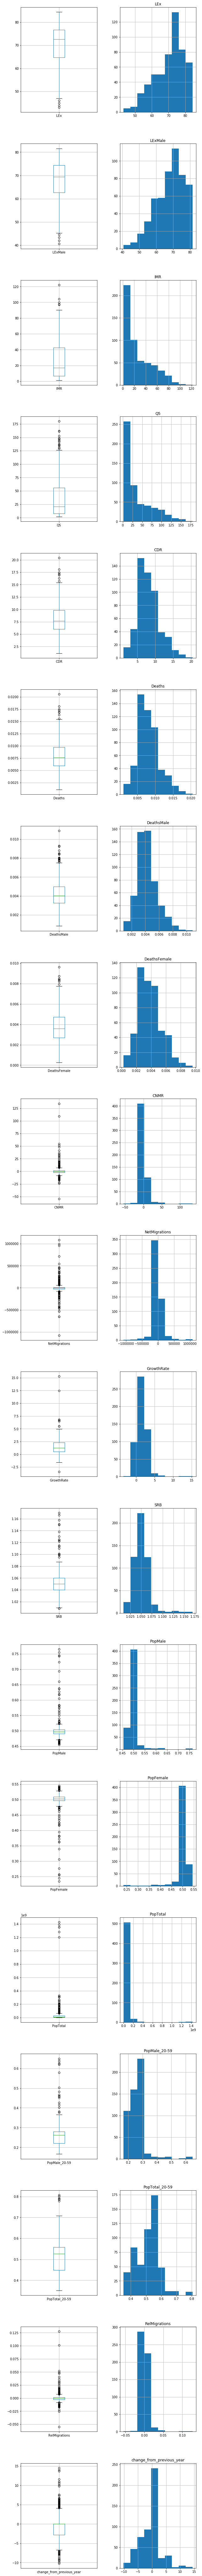

In [29]:
_, axes = plt.subplots(nrows=len(plot_cols), ncols=2, figsize=(10, 150))
for i, column in enumerate(plot_cols):
    small_set.boxplot(column=column, ax=axes[i][0])
    small_set.hist(column=column, ax=axes[i][1])
plt.show()

## Print rows of max outliers

In [44]:
max_indices = small_set[plot_cols].idxmax(axis=0)
for column in ["Deaths", "DeathsMale", "DeathsFemale", "CNMR", "GrowthRate", "RelMigrations", "change_from_previous_year"]:
    print(column + " with mean " + str(round(full_set[column].mean())))
    display(pd.DataFrame(full_set.loc[max_indices[column], :]).T)

Deaths with mean 0.0


,Country,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
276,Lesotho,2005-2010,2008,3.373,1.269,29.652,0.0297821,43.07,40.64,45.83,...,8.2,5.6,6,7.6,8.5,6.8,9.1,4.6,6.5,0


DeathsMale with mean 0.0


,Country,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
276,Lesotho,2005-2010,2008,3.373,1.269,29.652,0.0297821,43.07,40.64,45.83,...,8.2,5.6,6,7.6,8.5,6.8,9.1,4.6,6.5,0


DeathsFemale with mean 0.0


,Country,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
276,Lesotho,2005-2010,2008,3.373,1.269,29.652,0.0297821,43.07,40.64,45.83,...,8.2,5.6,6,7.6,8.5,6.8,9.1,4.6,6.5,0


CNMR with mean 1.0


,Country,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
390,Qatar,2005-2010,2008,2.23,1.075,12.568,0.0119046,78.69,77.59,80.29,...,4.6,5,3.3,6.8,2.6,5,4.7,3.3,4.9,0


GrowthRate with mean 1.0


,Country,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
390,Qatar,2005-2010,2008,2.23,1.075,12.568,0.0119046,78.69,77.59,80.29,...,4.6,5,3.3,6.8,2.6,5,4.7,3.3,4.9,0


RelMigrations with mean 0.0


,Country,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
390,Qatar,2005-2010,2008,2.23,1.075,12.568,0.0119046,78.69,77.59,80.29,...,4.6,5,3.3,6.8,2.6,5,4.7,3.3,4.9,0


change_from_previous_year with mean -1.0


,Country,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
283,Libya,2010-2015,2013,2.45,1.153,21.6,0.0215577,71.74,68.87,74.93,...,5,6.7,4.2,8.4,7.3,9,5.5,5.4,8.8,14.5


### Correlation of CNMR to

In [46]:
full_set[["GrowthRate", "RelMigrations"]].corrwith(full_set["CNMR"]).sort_values(ascending=False)

RelMigrations    0.999596
GrowthRate       0.693045
dtype: float64

### Correlation of GrowthRate to

In [49]:
full_set[["RelMigrations"]].corrwith(full_set["GrowthRate"]).sort_values(ascending=False)

RelMigrations    0.691197
dtype: float64

All outliers seem to be correct ones (no incorrect values). Outliers regarding the deaths belong to Lesotho, which seems reasonable, since it's an unstable country. The outliers in Growth rate, CNMR, and RelMigration all correlate to each other and all belong to Qatar. Thus the probability of correctness of the data is high.

# Descriptive Statistics
## Drop useless columns

In [51]:
drop_cols = ["Country", "Time", "MidPeriod", "country", "year", "ranking"]
small_set = full_set.drop(columns=drop_cols)

## Print statistics

In [52]:
small_set.describe()

,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,IMR,Q5,CDR,...,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention,change_from_previous_year
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.00000,533.000000,...,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,2.893216,1.289084,22.025328,0.021841,70.533114,68.120844,72.978968,26.467773,36.61022,8.110968,...,5.661407,6.260165,5.575598,6.245611,5.576009,5.837944,6.056620,5.079033,5.747296,-0.819700
std,1.443195,0.555984,10.678344,0.010519,8.652424,8.404099,9.017433,24.123972,37.23569,3.036740,...,1.978340,2.021099,2.057318,2.496367,2.485602,2.409381,2.275007,2.362487,2.354937,3.535141
min,1.110000,0.536000,7.436000,0.007417,43.070000,40.640000,45.830000,1.254000,1.76500,1.147000,...,1.200000,0.700000,1.000000,0.500000,0.700000,0.700000,1.000000,0.900000,0.700000,-10.200000
25%,1.764000,0.841000,12.345000,0.012087,64.680000,62.700000,66.600000,6.768000,7.92400,6.006000,...,4.100000,4.900000,4.100000,4.700000,3.700000,3.900000,4.300000,3.100000,4.200000,-2.800000
50%,2.400000,1.128000,20.019000,0.019810,72.660000,69.430000,75.670000,17.144000,20.51200,7.676000,...,5.800000,6.700000,6.000000,6.800000,5.800000,6.200000,6.300000,4.900000,6.100000,0.000000
75%,3.893000,1.758000,30.707000,0.030483,76.700000,74.360000,79.650000,42.624000,55.82700,9.794000,...,7.200000,7.800000,7.200000,8.200000,7.700000,7.655266,8.000000,7.000000,7.400000,0.000000
max,7.550000,3.000000,50.794000,0.050106,84.430000,81.600000,87.470000,122.090000,180.00600,20.439000,...,10.000000,9.768958,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,14.500000


## Plot heat map

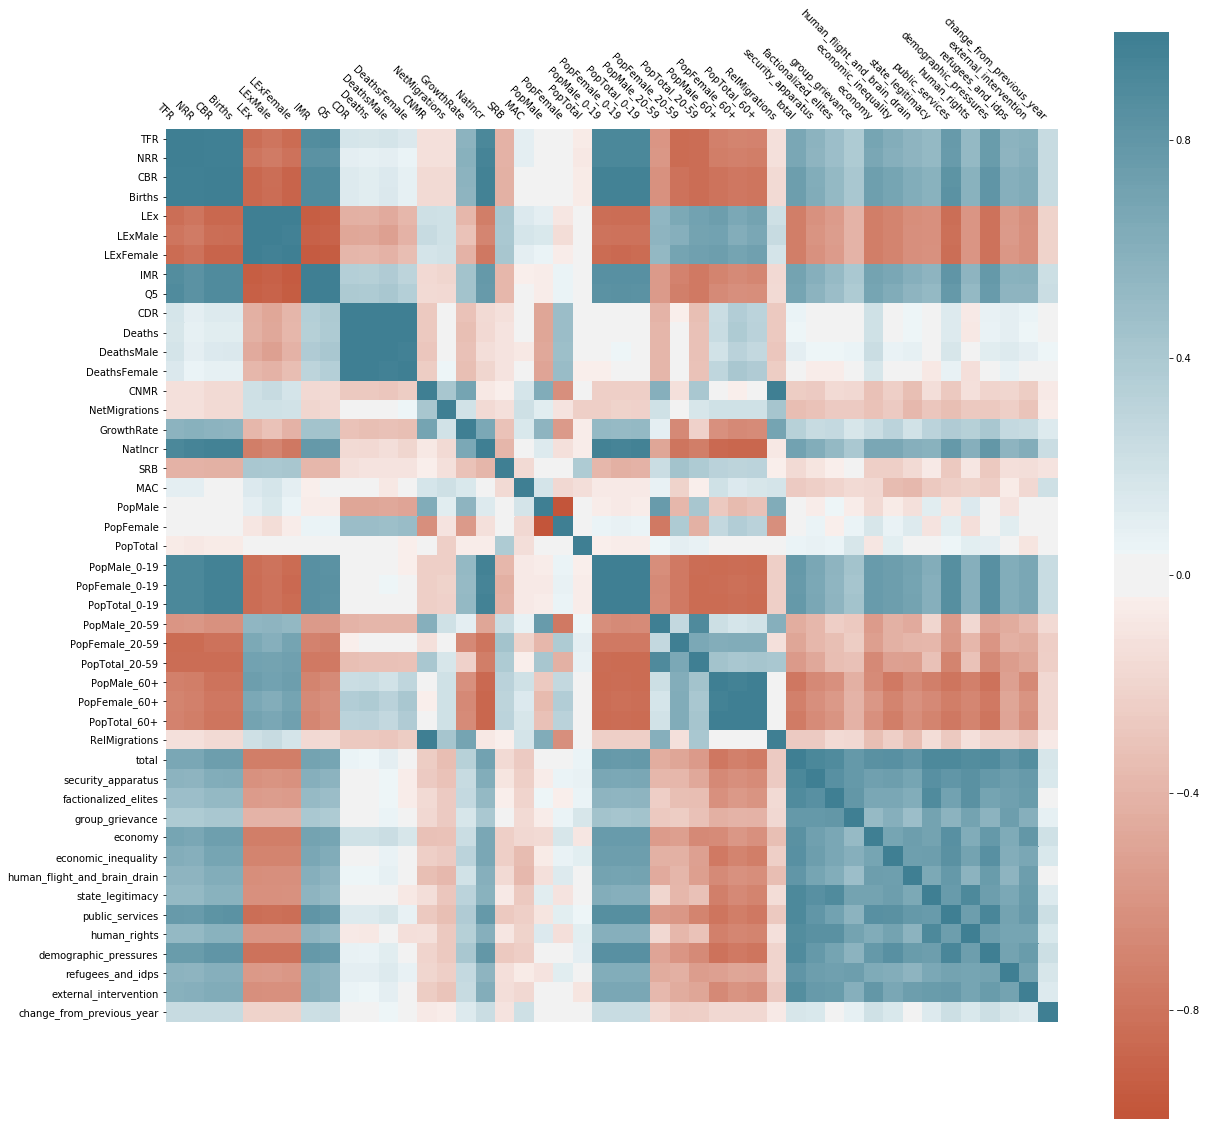

In [55]:
corr = small_set.corr()
plt.figure(figsize=(20, 20))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
ax = sns.heatmap(corr.iloc[:, :], vmin=-1, vmax=1, center=0,
                    cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, horizontalalignment='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.show()

The heat map shows that there are some bigger blocks in which the variable are strongly correlated to each other, e.g. TFR, NRR, CBR, Birth (all describe some birth statistics). An interesting observation for the population is that the numbers in age group 0-19 strongly correlate to each other but have also string anticorrelation to the numbers in age group 60+, i.e. high number of young means low older people and vice versa. But there are some variables which are independet from most of the others, like CNMR, NetMigration, RelMigration, PopTotal. Also interesting, that a high fragile state index correlates with high TFR, high ratio of young population, and low olders.

## Scatter plots
### `GrowthRate` vs `RelMigrations`

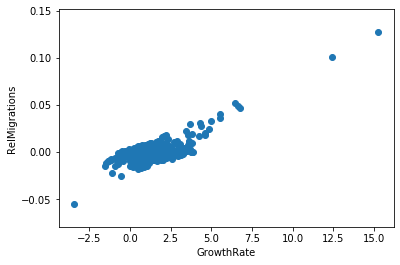

In [56]:
plt.scatter(x=full_set["GrowthRate"], y=full_set["RelMigrations"])
plt.xlabel("GrowthRate")
plt.ylabel("RelMigrations")
plt.show()

### `PopMale_20-59` vs `RelMigrations`

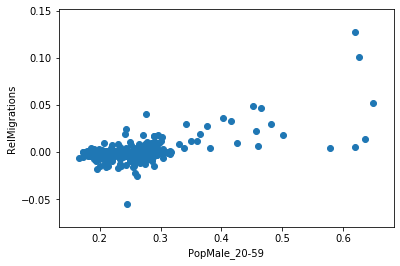

In [57]:
plt.scatter(x=full_set["PopMale_20-59"], y=full_set["RelMigrations"])
plt.xlabel("PopMale_20-59")
plt.ylabel("RelMigrations")
plt.show()

`RelMigrations` and `PopMale_20-59` have the highest feature importance according to our tests. This can also be expressed by the two scatter plots. A high value for both variables indicate high migration.